<a href="https://colab.research.google.com/github/tarun42/Flipr-Ml-Gryf1ndor/blob/master/Flipr_Part_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import math
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")
from google.colab import files
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn.model_selection import train_test_split 
from sklearn.ensemble import RandomForestRegressor,  GradientBoostingRegressor
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import KFold, cross_val_score, train_test_split
import xgboost as xgb
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import PolynomialFeatures
from sklearn import metrics
from sklearn.inspection import permutation_importance


/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
#upload dataset
uploaded = files.upload()

Saving Train_dataset.xlsx to Train_dataset.xlsx


In [57]:
#load dataset
df = pd.read_excel("Train_dataset.xlsx", sheet_name=0)
#missing values
df.isnull().sum()

City                   0
State                  0
Type                   0
Population [2011]     48
Popuation [2001]     492
Sex Ratio             10
Median Age            18
Avg Temp              17
SWM                    4
Toilets Avl           26
Water Purity         158
H Index              140
Female Population    141
# of hospitals        15
Foreign Visitors      90
Covid Cases            0
dtype: int64

In [58]:
#handling data errors
print(df['Type'].unique())
df['Type'] = df['Type'].str.replace('.','')
print(df['Type'].unique())


['M.C' 'MPUA' 'T' 'M' 'C-1T' 'M.Cl' 'M.Corp' 'N.P' 'UA' 'M.B.' 'N.Pd'
 'M.Cl.' 'M.B' 'N.P.P' 'CMC' 'C.T' 'C.M.C' 'N.P.' 'Nagar Parishad' 'N.A.C'
 'MB' 'M Cl' 'M.Corp.' 'U.A' 'N.P.P.' 'T.C' 'T.M.C' 'N.T' 'C.B' 'NPP'
 'T.M.C.' 'NP' 'Np' 'C.T.' 'T.P' 'N.A' 'T.P.']
['MC' 'MPUA' 'T' 'M' 'C-1T' 'MCl' 'MCorp' 'NP' 'UA' 'MB' 'NPd' 'NPP' 'CMC'
 'CT' 'Nagar Parishad' 'NAC' 'M Cl' 'TC' 'TMC' 'NT' 'CB' 'Np' 'TP' 'NA']


In [59]:
df.head()

,City,State,Type,Population [2011],Popuation [2001],Sex Ratio,Median Age,Avg Temp,SWM,Toilets Avl,Water Purity,H Index,Female Population,# of hospitals,Foreign Visitors,Covid Cases
0,Mumbai,Maharashtra,MC,12442373.0,11978450.0,878.0,23.0,32.0,MEDIUM,219.0,150.0,0.700440,10924403.0,159.0,4408916.0,163115
1,Delhi,Delhi,MC,11007835.0,9879172.0,858.0,27.0,30.0,MEDIUM,215.0,196.0,0.920018,9444722.0,148.0,2379169.0,80188
2,Bangalore,Karnataka,MPUA,8436675.0,4301326.0,936.0,28.0,37.0,HIGH,212.0,102.0,0.097085,7896728.0,123.0,636502.0,141000
3,Hyderabad,Telangana,MPUA,6809970.0,3637483.0,930.0,23.0,31.0,MEDIUM,217.0,118.0,0.827744,6333272.0,110.0,126078.0,55123
4,Ahmedabad,Gujarat,MPUA,5570585.0,3520085.0,852.0,29.0,25.0,LOW,227.0,109.0,0.847941,4746138.0,73.0,284973.0,33204


# Handling Missing values 

In [60]:
l_population2011=[]

#filing missing values of population by sex ratio and female population
for i in range(len(df.values)):
  if(math.isnan(df['Population [2011]'][i]) and (not math.isnan(df['Female Population'][i])) and (not math.isnan(df['Sex Ratio'][i]))):
    df['Population [2011]'][i]=(df['Female Population'][i]/(1000*df['Sex Ratio'][i]))+df['Female Population'][i]
    # print("hello")
  if((not math.isnan(df['Population [2011]'][i])) and ( math.isnan(df['Female Population'][i])) and (not math.isnan(df['Sex Ratio'][i]))):
    df['Female Population'][i]=df['Population [2011]'][i]*(1000*df['Sex Ratio'][i])/(1+(1000*df['Sex Ratio'][i]))
  
  if((not math.isnan(df['Population [2011]'][i])) and ( not math.isnan(df['Female Population'][i])) and ( math.isnan(df['Sex Ratio'][i]))):
    df['Sex Ratio'][i]=df['Female Population'][i]/(1000*(df['Population [2011]'][i]-df['Female Population'][i]))

In [61]:
#Handling Missing values for Purity
df['Water Purity']=df['Water Purity'].fillna((df['Water Purity'].mean()))  

In [62]:
#Handling Missing values for Foregin Visitors by state
grouped = df.groupby('State')
j = 0
i=0
means={}
for col,group in grouped:
    means[col] = group['Foreign Visitors'].mean()                          
    #print(col)
for i in range(len(df.values)):
  if(math.isnan(df['Foreign Visitors'][i])):
    #print(df3['State'][i])
    j+=1
    df['Foreign Visitors'][i] = means[df['State'][i]]

In [63]:
#Handling Missing values for Toilets by city type 
grouped = df.groupby('Type')
j = 0
i=0
means={}
for col,group in grouped:
    means[col] = group['Toilets Avl'].mean()                         
    
for i in range(len(df.values)):
  if(math.isnan(df['Toilets Avl'][i])):   
    j+=1
    df['Toilets Avl'][i] = means[df['Type'][i]]

In [64]:
#Handling Missing values for Tempearture by state
grouped = df.groupby('State')
j = 0
i=0
means={}
for col,group in grouped:
    means[col] = group['Avg Temp'].mean()                           
    
for i in range(len(df.values)):
  if(math.isnan(df['Avg Temp'][i])):
    
    j+=1
    df['Avg Temp'][i] = means[df['State'][i]]
for i in range(len(df.values)):
    if(df['State'][i] == "Sikkim"):
        df['Avg Temp'][i] = means['Assam']
    if(df['State'][i] == "Andaman and Nicobar Islands"):
        df['Avg Temp'][i] = 23

In [65]:
#Handling Missing values for hospitals by type of city
grouped = df.groupby('Type')
j = 0
i=0
means1={}
for col,group in grouped:
    means1[col] = group['# of hospitals'].mean()                           #imputer hospitals
    
for i in range(len(df.values)):
  if(math.isnan(df['# of hospitals'][i])):
    
    j+=1
    df['# of hospitals'][i] = means1[df['Type'][i]]


In [66]:
#missing values
df.isnull().sum()

City                   0
State                  0
Type                   0
Population [2011]      7
Popuation [2001]     492
Sex Ratio              0
Median Age            18
Avg Temp               0
SWM                    4
Toilets Avl            0
Water Purity           0
H Index              140
Female Population      7
# of hospitals         0
Foreign Visitors       0
Covid Cases            0
dtype: int64

# Feature Selection

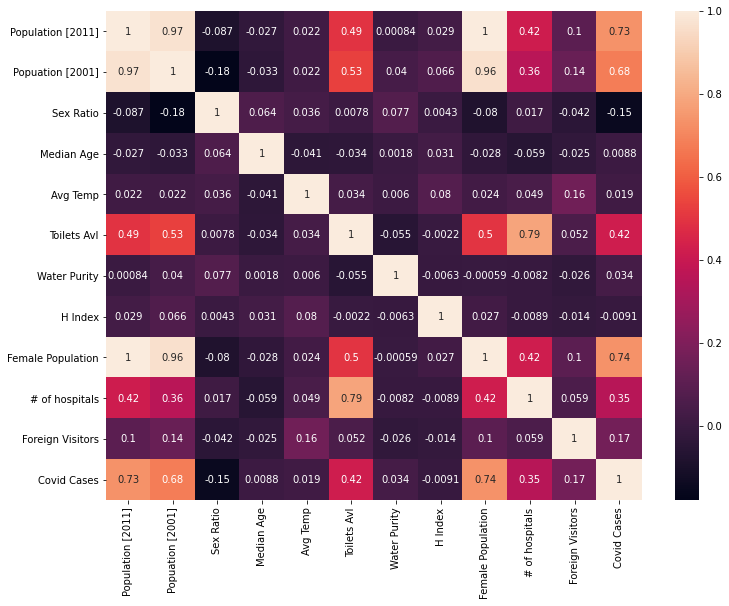

In [67]:
plt.figure(figsize=(12, 9))
sns.heatmap(df.corr(), annot=True)

In [68]:
#dropping these columns due to low correlation with covid cases
df = df.drop(['H Index','Popuation [2001]','Median Age'], axis = 1)
df.head()

,City,State,Type,Population [2011],Sex Ratio,Avg Temp,SWM,Toilets Avl,Water Purity,Female Population,# of hospitals,Foreign Visitors,Covid Cases
0,Mumbai,Maharashtra,MC,12442373.0,878.0,32.0,MEDIUM,219.0,150.0,10924403.0,159.0,4408916.0,163115
1,Delhi,Delhi,MC,11007835.0,858.0,30.0,MEDIUM,215.0,196.0,9444722.0,148.0,2379169.0,80188
2,Bangalore,Karnataka,MPUA,8436675.0,936.0,37.0,HIGH,212.0,102.0,7896728.0,123.0,636502.0,141000
3,Hyderabad,Telangana,MPUA,6809970.0,930.0,31.0,MEDIUM,217.0,118.0,6333272.0,110.0,126078.0,55123
4,Ahmedabad,Gujarat,MPUA,5570585.0,852.0,25.0,LOW,227.0,109.0,4746138.0,73.0,284973.0,33204


In [69]:
## SWM encoding
j = 0
swm = {}
for i in df['SWM'].unique():
  if j<3:
    swm[i] = j
    j+=1
for i in range(len(df)):
  if df['SWM'][i] in swm.keys():
    df['SWM'][i] = swm[df['SWM'][i]]
print(df['SWM'].unique())

[0 1 2 nan]


In [70]:
## state encoding
j = 0
state = {}
for i in df['State'].unique():
  state[i] = j
  j+=1
for i in range(len(df)):
  if df['State'][i] in state.keys():
    df['State'][i] = state[df['State'][i]]
print(df['State'].unique())

[0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27
 28 29 30 31 32]


In [71]:
## city type encoding
j = 0
c_type = {}
print(df['Type'].unique())
for i in df['Type'].unique():
  c_type[i] = j
  j+=1
for i in range(len(df)):
  if df['Type'][i] in c_type.keys():
    df['Type'][i] = c_type[df['Type'][i]]
print(df['Type'].unique())

['MC' 'MPUA' 'T' 'M' 'C-1T' 'MCl' 'MCorp' 'NP' 'UA' 'MB' 'NPd' 'NPP' 'CMC'
 'CT' 'Nagar Parishad' 'NAC' 'M Cl' 'TC' 'TMC' 'NT' 'CB' 'Np' 'TP' 'NA']
[0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]


In [72]:
df.head()

,City,State,Type,Population [2011],Sex Ratio,Avg Temp,SWM,Toilets Avl,Water Purity,Female Population,# of hospitals,Foreign Visitors,Covid Cases
0,Mumbai,0,0,12442373.0,878.0,32.0,0,219.0,150.0,10924403.0,159.0,4408916.0,163115
1,Delhi,1,0,11007835.0,858.0,30.0,0,215.0,196.0,9444722.0,148.0,2379169.0,80188
2,Bangalore,2,1,8436675.0,936.0,37.0,1,212.0,102.0,7896728.0,123.0,636502.0,141000
3,Hyderabad,3,1,6809970.0,930.0,31.0,0,217.0,118.0,6333272.0,110.0,126078.0,55123
4,Ahmedabad,4,1,5570585.0,852.0,25.0,2,227.0,109.0,4746138.0,73.0,284973.0,33204


In [ ]:
df = df.drop(['City'], axis = 1)


In [89]:
df.dropna(inplace = True)
df.isnull().sum()

State                0
Type                 0
Population [2011]    0
Sex Ratio            0
Avg Temp             0
SWM                  0
Toilets Avl          0
Water Purity         0
Female Population    0
# of hospitals       0
Foreign Visitors     0
Covid Cases          0
dtype: int64

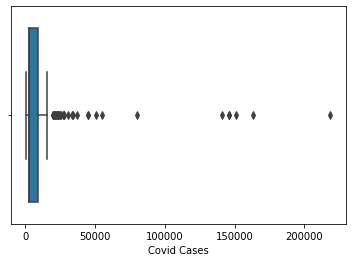

In [79]:
#outliers
df['Covid Cases'].describe()
import seaborn as sns
sns.boxplot(df['Covid Cases'])

In [81]:
Q1 = df['Covid Cases'].quantile(0.25)
Q3 = df['Covid Cases'].quantile(0.75)
IQR = Q3 - Q1
outliers = df[((df['Covid Cases'] < (Q1 - 1.5 * IQR)) | (df['Covid Cases'] > (Q3 + 1.5 * IQR)))].index
#removed rows having outliers of covid cases 
df.drop(outliers , inplace = True)

In [82]:
df.head()

,State,Type,Population [2011],Sex Ratio,Avg Temp,SWM,Toilets Avl,Water Purity,Female Population,# of hospitals,Foreign Visitors,Covid Cases
10,8,1,3046163.0,871.0,32.0,1,128.0,172.0,2653208.0,61.0,1475311.0,14001
12,10,3,2800000.0,919.0,34.0,2,116.0,142.0,2573200.0,56.0,421365.0,15764
15,10,1,1964086.0,929.0,37.0,0,149.0,172.0,1824636.0,76.0,421365.0,15764
17,10,1,1798218.0,926.0,35.0,2,113.0,185.0,1665150.0,72.0,421365.0,12446
21,4,1,1670806.0,840.0,29.0,2,112.0,156.0,1403477.0,91.0,284973.0,9439


In [90]:
#separting x and y
X = df.iloc[:, :-1].values
y = df.iloc[:, -1:].values
print(y[0:5])
print(X[0:5])

[[14001]
 [15764]
 [15764]
 [12446]
 [ 9439]]
[[8 1 3046163.0 871.0 32.0 1 128.0 172.0 2653208.0 61.0 1475311.0]
 [10 3 2800000.0 919.0 34.0 2 116.0 142.0 2573200.0 56.0 421365.0]
 [10 1 1964086.0 929.0 37.0 0 149.0 172.0 1824636.0 76.0 421365.0]
 [10 1 1798218.0 926.0 35.0 2 113.0 185.0 1665150.0 72.0 421365.0]
 [4 1 1670806.0 840.0 29.0 2 112.0 156.0 1403477.0 91.0 284973.0]]


In [91]:
#normalise train dataset
mm_scaler = preprocessing.MinMaxScaler()
Train_minmax = mm_scaler.fit_transform(X)
X=pd.DataFrame(Train_minmax)
X.head()

,0,1,2,3,4,5,6,7,8,9,10
0,0.2500,0.043478,1.000000,0.835891,0.771429,0.5,0.78,0.72,1.000000,0.566667,0.314804
1,0.3125,0.130435,0.918251,0.881957,0.828571,1.0,0.66,0.42,0.969489,0.511111,0.089790
2,0.3125,0.043478,0.640651,0.891554,0.914286,0.0,0.99,0.72,0.684028,0.733333,0.089790
3,0.3125,0.043478,0.585568,0.888675,0.857143,1.0,0.63,0.85,0.623209,0.688889,0.089790
4,0.1250,0.043478,0.543255,0.806141,0.685714,1.0,0.62,0.56,0.523421,0.900000,0.060670


In [92]:
#splitting into train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(596, 11)
(596, 1)
(150, 11)
(150, 1)


# Best model - XGBoost - Training

In [93]:
def rmsle(y, y_pred):
    return np.sqrt(mean_squared_error(y, y_pred))

In [105]:
model_xgb = xgb.XGBRegressor(colsample_bytree=0.4603, gamma=0.0468, 
                             learning_rate=0.05, max_depth=10, 
                             min_child_weight=1.7817, n_estimators=2200,
                             reg_alpha=0.4640, reg_lambda=0.8571,
                             subsample=1,silent=1,
                             random_state =25, nthread = -1 , booster = 'gbtree')

In [108]:
n_folds = 5
def rmsle_cv(model):
    kf = KFold(n_folds, shuffle=True, random_state=42).get_n_splits(X_train)
    rmse= np.sqrt(-cross_val_score(model, X_train, y_train, scoring="neg_mean_squared_error", cv = kf))
    return(rmse)

score = rmsle_cv(model_xgb)
model_xgb.fit(X_train, y_train)
y_hat = model_xgb.predict(X_test)

print("Xgboost score for kfold: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))
print("rmse ",rmsle(y_test, y_hat))
print("Mean absolute error: %.2f" % np.mean(np.absolute(y_hat - y_test)))
print("R2-score: %.2f" % r2_score(y_hat , y_test) )

Xgboost score for kfold: 1896.4720 (148.2320)

rmse  1491.8522355978814
Mean absolute error: 3378.22
R2-score: 0.77


In [109]:
#tells how good rmse is :
print("SI INDEX : ",rmsle(y_test, y_hat) / y.mean())

SI INDEX :  0.3272515838137633


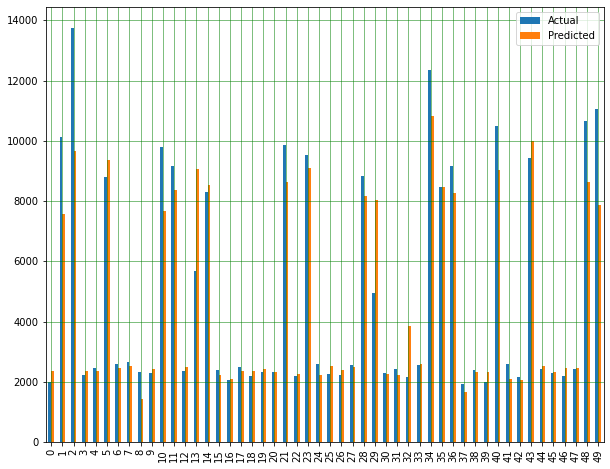

In [110]:
y_t = []
for i in y_test:
  y_t.append(i[0])
y_p = []
# for i in y_hat:
#   y_p.append(i[0])

df = pd.DataFrame({'Actual': y_t, 'Predicted': y_hat})
df1 = df.head(50)
df1.plot(kind='bar',figsize=(10,8))
plt.grid(which='major', linestyle='-', linewidth='0.5', color='green')
plt.grid(which='minor', linestyle=':', linewidth='0.5', color='black')
plt.savefig("xgboost.jpeg")
plt.show()

# Test Dataset - final results

In [112]:
#upload test dataset
uploaded = files.upload()

Saving Test_dataset.xlsx to Test_dataset.xlsx


In [114]:
test = pd.read_excel("Test_dataset.xlsx", sheet_name=0)
test.head()

,City,State,Type,Population [2011],Popuation [2001],Sex Ratio,Median Age,Avg Temp,SWM,Toilets Avl,Water Purity,H Index,Female Population,# of hospitals,Foreign Visitors
0,Tuensang,Nagaland,T.C,36774.0,NaN,931.0,23.0,10.0,MEDIUM,94.0,114.0,0.253390,34237.0,17.0,2769.0
1,Lakshmeshwar,Karnataka,T.M.C,36754.0,NaN,934.0,25.0,38.0,HIGH,62.0,160.0,0.192555,34328.0,13.0,636502.0
2,Zira,Punjab,M.Cl.,36732.0,NaN,883.0,29.0,35.0,HIGH,63.0,105.0,0.887882,32434.0,17.0,242367.0
3,Yawal,Maharashtra,M.Cl,36706.0,NaN,887.0,26.0,31.0,HIGH,60.0,174.0,0.407838,32558.0,11.0,4408916.0
4,Thana Bhawan,Uttar Pradesh,N.P.,36669.0,NaN,877.0,28.0,39.0,LOW,92.0,153.0,0.324456,32159.0,23.0,3104060.0


In [115]:
#dropping not required columns
test = test.drop(['H Index','Popuation [2001]','Median Age'], axis = 1)
test.head()

,City,State,Type,Population [2011],Sex Ratio,Avg Temp,SWM,Toilets Avl,Water Purity,Female Population,# of hospitals,Foreign Visitors
0,Tuensang,Nagaland,T.C,36774.0,931.0,10.0,MEDIUM,94.0,114.0,34237.0,17.0,2769.0
1,Lakshmeshwar,Karnataka,T.M.C,36754.0,934.0,38.0,HIGH,62.0,160.0,34328.0,13.0,636502.0
2,Zira,Punjab,M.Cl.,36732.0,883.0,35.0,HIGH,63.0,105.0,32434.0,17.0,242367.0
3,Yawal,Maharashtra,M.Cl,36706.0,887.0,31.0,HIGH,60.0,174.0,32558.0,11.0,4408916.0
4,Thana Bhawan,Uttar Pradesh,N.P.,36669.0,877.0,39.0,LOW,92.0,153.0,32159.0,23.0,3104060.0


In [117]:
#handling data errors
print(test['Type'].unique())
test['Type'] = test['Type'].str.replace('.','')
print(test['Type'].unique())

['T.C' 'T.M.C' 'M.Cl.' 'M.Cl' 'N.P.' 'UA' 'M' 'N.T' 'T.M.C.' 'N.P' 'C.T'
 'M.B' 'T.C.' 'I.N.A' 'N.P.P' 'N.A' 'N.A.C' 'M.C' 'M.B.' 'M.C.' 'TP'
 'N.P.P.' 'T.P' 'NAC' 'T.P.' 'G.P' 'C.T.' 'NP' 'M&F' nan 'CT' 'G.P.'
 'N.A.C.']
['TC' 'TMC' 'MCl' 'NP' 'UA' 'M' 'NT' 'CT' 'MB' 'INA' 'NPP' 'NA' 'NAC' 'MC'
 'TP' 'GP' 'M&F' nan]


In [118]:
test.isnull().sum()

City                  0
State                 0
Type                  2
Population [2011]     6
Sex Ratio             5
Avg Temp             14
SWM                   9
Toilets Avl          22
Water Purity         19
Female Population    15
# of hospitals       17
Foreign Visitors     17
dtype: int64

# Handling missing values in test dataset

In [120]:
test['Water Purity']=test['Water Purity'].fillna((test['Water Purity'].mean()))  

In [143]:
test.isnull().sum()

City                  0
State                 0
Type                  2
Population [2011]     6
Sex Ratio             5
Avg Temp              1
SWM                   9
Toilets Avl           1
Water Purity          0
Female Population    15
# of hospitals       17
Foreign Visitors      0
dtype: int64

In [122]:
grouped = test.groupby('State')
j = 0
i=0
means={}
for col,group in grouped:
    means[col] = group['Foreign Visitors'].mean()                        
    #print(col)
for i in range(len(test.values)):
  if(math.isnan(test['Foreign Visitors'][i])):
    
    j+=1
    test['Foreign Visitors'][i] = means[test['State'][i]]


In [138]:
#Handling Missing values for Toilets by city type 
df3 = test
grouped = df3.groupby('Type')
j = 0
i=0
means={}
for col,group in grouped:
    a = col.replace('.','')
    means[a] = group['Toilets Avl'].mean()
print(means)
for i in range(len(df3.values)):
  if(math.isnan(df3['Toilets Avl'][i]) and not (df3['Type'][i]!=df3['Type'][i])):
    a = df3['Type'][i].replace('.','')
    j+=1
    df3['Toilets Avl'][i] = means[a]


print(df3['Type'].unique())
df3.isnull().sum()

{'CT': 66.22222222222221, 'GP': 41.25, 'INA': 84.0, 'M': 78.05982905982904, 'M&F': 79.0, 'MB': 70.52941176470588, 'MC': 81.1, 'MCl': 74.86153846153847, 'NA': 80.44444444444444, 'NAC': 65.6, 'NP': 63.476190476190496, 'NPP': 64.21739130434783, 'NT': 99.5, 'TC': 81.8, 'TMC': 72.66666666666667, 'TP': 74.89130434782608, 'UA': 80.25}
['TC' 'TMC' 'MCl' 'NP' 'UA' 'M' 'NT' 'CT' 'MB' 'INA' 'NPP' 'NA' 'NAC' 'MC'
 'TP' 'GP' 'M&F' nan]


City                  0
State                 0
Type                  2
Population [2011]     6
Sex Ratio             5
Avg Temp              1
SWM                   9
Toilets Avl           1
Water Purity          0
Female Population    15
# of hospitals       17
Foreign Visitors      0
dtype: int64

In [139]:
grouped = df3.groupby('State')
j = 0
i=0
means={}
for col,group in grouped:
    means[col] = group['Avg Temp'].mean()                           #imputer Temp
    
for i in range(len(df3.values)):
  if(math.isnan(df3['Avg Temp'][i])):
    
    j+=1
    df3['Avg Temp'][i] = means[df3['State'][i]]
print(df3['Type'].unique())

['TC' 'TMC' 'MCl' 'NP' 'UA' 'M' 'NT' 'CT' 'MB' 'INA' 'NPP' 'NA' 'NAC' 'MC'
 'TP' 'GP' 'M&F' nan]


In [140]:
test[test['Avg Temp'].isnull()]

,City,State,Type,Population [2011],Sex Ratio,Avg Temp,SWM,Toilets Avl,Water Purity,Female Population,# of hospitals,Foreign Visitors
359,Silvassa,Dadra and Nagar Haveli,CT,21893.0,774.0,NaN,MEDIUM,98.0,135.0,16945.0,22.0,1797.0


In [146]:
grouped = df3.groupby('Type')
j = 0
i=0
means1={}
for col,group in grouped:
    a = col.replace('.','')
    means1[a] = group['# of hospitals'].mean()                           #imputer hospitals
    
for i in range(len(df3.values)and not (df3['Type'][i]!=df3['Type'][i])):
  if(math.isnan(df3['# of hospitals'][i])):
    a = df3['Type'][i].replace('.','')
    j+=1
    df3['# of hospitals'][i] = means1[a]
df3.isnull().sum()

City                  0
State                 0
Type                  2
Population [2011]     6
Sex Ratio             5
Avg Temp              1
SWM                   9
Toilets Avl           1
Water Purity          0
Female Population    15
# of hospitals       17
Foreign Visitors      0
dtype: int64

In [157]:
df3['Sex Ratio']=df3['Sex Ratio'].fillna((df3['Sex Ratio'].mean())) 
x = ["Sex Ratio","Avg Temp","Toilets Avl","# of hospitals",'Population [2011]']
for i in x:
  print(i)
  df3[i]=df3[i].fillna((df3[i].mean())) 
df3.isnull().sum()

Sex Ratio
Avg Temp
Toilets Avl
# of hospitals
Population [2011]


City                 0
State                0
Type                 2
Population [2011]    0
Sex Ratio            0
Avg Temp             0
SWM                  9
Toilets Avl          0
Water Purity         0
Female Population    0
# of hospitals       0
Foreign Visitors     0
dtype: int64

In [151]:
df = df3
for i in range(len(df.values)):
  if(math.isnan(df['Population [2011]'][i]) and (not math.isnan(df['Female Population'][i])) and (not math.isnan(df['Sex Ratio'][i]))):
    df['Population [2011]'][i]=(df['Female Population'][i]/(1000*df['Sex Ratio'][i]))+df['Female Population'][i]
    # print("hello")
  if((not math.isnan(df['Population [2011]'][i])) and ( math.isnan(df['Female Population'][i])) and (not math.isnan(df['Sex Ratio'][i]))):
    df['Female Population'][i]=df['Population [2011]'][i]*(1000*df['Sex Ratio'][i])/(1+(1000*df['Sex Ratio'][i]))
  
  if((not math.isnan(df['Population [2011]'][i])) and ( not math.isnan(df['Female Population'][i])) and ( math.isnan(df['Sex Ratio'][i]))):
    df['Sex Ratio'][i]=df['Female Population'][i]/(1000*(df['Population [2011]'][i]-df['Female Population'][i]))
df.isnull().sum()
print(df['Type'].unique())

['TC' 'TMC' 'MCl' 'NP' 'UA' 'M' 'NT' 'CT' 'MB' 'INA' 'NPP' 'NA' 'NAC' 'MC'
 'TP' 'GP' 'M&F' nan]


In [152]:
df3.isnull().sum()

City                 0
State                0
Type                 2
Population [2011]    0
Sex Ratio            0
Avg Temp             0
SWM                  9
Toilets Avl          0
Water Purity         0
Female Population    0
# of hospitals       0
Foreign Visitors     0
dtype: int64

In [153]:
## SWM encoding
j = 0
swm = {'MEDIUM': 0, 'HIGH': 1, 'LOW': 2}
for i in range(len(df3)):
  if df3['SWM'][i] in swm.keys():
    df3['SWM'][i] = swm[df3['SWM'][i]]
print(df3['SWM'].unique())
print(df3['Type'].unique())

[0 1 2 nan]
['TC' 'TMC' 'MCl' 'NP' 'UA' 'M' 'NT' 'CT' 'MB' 'INA' 'NPP' 'NA' 'NAC' 'MC'
 'TP' 'GP' 'M&F' nan]


In [154]:
state = {'Maharashtra': 0, 'Delhi': 1, 'Karnataka': 2, 'Telangana': 3, 'Gujarat': 4, 'Tamil Nadu': 5, 'Tamil nadu': 6, 'West Bengal': 7, 'Rajasthan': 8, 'Uttar Pradesh': 9, 'Madhya Pradesh': 10, 'Andhra Pradesh': 11, 'Bihar': 12, 'Punjab': 13, 'Jharkhand': 14, 'Haryana': 15, 'Jammu and Kashmir': 16, 'Chandigarh': 17, 'Chhattisgarh': 18, 'Assam': 19, 'Odisha': 20, 'Kerala': 21, 'Uttarakhand': 22, 'Tripura': 23, 'Puducherry': 24, 'Mizoram': 25, 'Manipur': 26, 'Himachal Pradesh': 27, 'Sikkim': 28, 'Andaman and Nicobar Islands': 29, 'Goa': 30, 'Nagaland': 31, 'Meghalaya': 32, 'Arunachal Pradesh' : 33, 'Dadra and Nagar Haveli':34, 'Andhra pradesh': 11}
for i in range(len(df3)):
  if df3['State'][i] in state.keys():
    df3['State'][i] = state[df3['State'][i]]
print(df3['State'].unique())
print(df3['Type'].unique())

[31 2 13 0 9 3 8 7 33 14 10 11 16 5 4 27 22 12 21 20 15 23 18 19 32 26 34
 25]
['TC' 'TMC' 'MCl' 'NP' 'UA' 'M' 'NT' 'CT' 'MB' 'INA' 'NPP' 'NA' 'NAC' 'MC'
 'TP' 'GP' 'M&F' nan]


In [155]:
j = 0
c_type = {}
for i in df3['Type'].unique():
  if(not (i!=i)):
    a = i.replace('.','')
    if a not in c_type.keys():
      c_type[a] = j
      print(j)
      j+=1


for i in range(len(df3)):
  if(not (df3['Type'][i]!=df3['Type'][i])):
    a = df3['Type'][i].replace('.','')
    if a in c_type.keys():
      df3['Type'][i] = c_type[a]
print(df3['Type'].unique())

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
[0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 nan]


In [161]:
df3.isnull().sum()

City                 0
State                0
Type                 0
Population [2011]    0
Sex Ratio            0
Avg Temp             0
SWM                  0
Toilets Avl          0
Water Purity         0
Female Population    0
# of hospitals       0
Foreign Visitors     0
dtype: int64

In [159]:
print(df3["SWM"].unique())
df3['Type']=df3['Type'].fillna((0)) 

df3['SWM']=df3['SWM'].fillna((0)) 

[0 1 2 nan]


In [160]:
Cities = df3[["City"]]
x_dataset = df3[['State','Type','Population [2011]','Sex Ratio','Avg Temp','SWM','Toilets Avl','Water Purity','Female Population','# of hospitals','Foreign Visitors']]
x_dataset['Type'].unique()

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16])

In [162]:
Cities = df3[["City"]]
x_dataset = df3[['State','Type','Population [2011]','Sex Ratio','Avg Temp','SWM','Toilets Avl','Water Purity','Female Population','# of hospitals','Foreign Visitors']]
x_dataset['Type'].unique()

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16])

In [163]:
Cities.insert(1, "Covid Cases", Cities, True)

In [164]:
Cities

,City,Covid Cases
0,Tuensang,Tuensang
1,Lakshmeshwar,Lakshmeshwar
2,Zira,Zira
3,Yawal,Yawal
4,Thana Bhawan,Thana Bhawan
...,...,...
496,Nandaprayag,Nandaprayag
497,Kirtinagar,Kirtinagar
498,Kedarnath,Kedarnath
499,Gangotri,Gangotri


In [165]:
df3.head()

,City,State,Type,Population [2011],Sex Ratio,Avg Temp,SWM,Toilets Avl,Water Purity,Female Population,# of hospitals,Foreign Visitors
0,Tuensang,31,0,36774.0,931.0,10.0,0,94.0,114.0,34237.0,17.0,2769.0
1,Lakshmeshwar,2,1,36754.0,934.0,38.0,1,62.0,160.0,34328.0,13.0,636502.0
2,Zira,13,2,36732.0,883.0,35.0,1,63.0,105.0,32434.0,17.0,242367.0
3,Yawal,0,2,36706.0,887.0,31.0,1,60.0,174.0,32558.0,11.0,4408916.0
4,Thana Bhawan,9,3,36669.0,877.0,39.0,2,92.0,153.0,32159.0,23.0,3104060.0


In [171]:
df3 = df3.drop(['City'], axis = 1)

In [168]:
df3 = df.drop(['H Index','Popuation [2001]','Median Age'], axis = 1)


KeyError: ignored

In [172]:

df3.head()

,State,Type,Population [2011],Sex Ratio,Avg Temp,SWM,Toilets Avl,Water Purity,Female Population,# of hospitals,Foreign Visitors
0,31,0,36774.0,931.0,10.0,0,94.0,114.0,34237.0,17.0,2769.0
1,2,1,36754.0,934.0,38.0,1,62.0,160.0,34328.0,13.0,636502.0
2,13,2,36732.0,883.0,35.0,1,63.0,105.0,32434.0,17.0,242367.0
3,0,2,36706.0,887.0,31.0,1,60.0,174.0,32558.0,11.0,4408916.0
4,9,3,36669.0,877.0,39.0,2,92.0,153.0,32159.0,23.0,3104060.0


In [173]:
#normalise train dataset
mm_scaler = preprocessing.MinMaxScaler()
Train_minmax = mm_scaler.fit_transform(df3)
X=pd.DataFrame(Train_minmax)
X.head()

,0,1,2,3,4,5,6,7,8,9,10
0,0.911765,0.0000,1.000000,0.723502,0.142857,0.0,0.933333,0.14,0.991315,0.518519,0.000421
1,0.058824,0.0625,0.999455,0.737327,0.942857,0.5,0.577778,0.60,0.993950,0.370370,0.135721
2,0.382353,0.1250,0.998854,0.502304,0.857143,0.5,0.588889,0.05,0.939110,0.518519,0.051574
3,0.000000,0.1250,0.998145,0.520737,0.742857,0.5,0.555556,0.74,0.942700,0.296296,0.941119
4,0.264706,0.1875,0.997136,0.474654,0.971429,1.0,0.911111,0.53,0.931147,0.740741,0.662537


In [174]:
y_hat = model_xgb.predict(X)

In [176]:
y_hat

array([11194.627 , 11467.832 , 12627.778 ,  8276.431 ,  8416.204 ,
       10620.774 ,  7998.1284, 10046.339 , 11654.808 , 10077.748 ,
       12172.008 ,  9953.106 , 10419.954 ,  9818.996 ,  8947.3125,
       10826.651 ,  9080.658 , 10083.155 , 10643.711 ,  9850.684 ,
       11220.244 , 10302.75  ,  9620.09  ,  7949.084 , 10452.736 ,
       12834.237 ,  8978.396 ,  8239.703 ,  9837.669 ,  8842.041 ,
       11715.017 , 12575.385 , 12050.157 , 10025.435 , 10094.375 ,
       11149.229 ,  9345.13  , 12428.697 ,  9786.245 , 10084.207 ,
       10978.08  ,  7498.8906, 13190.171 ,  9422.419 ,  9309.397 ,
       11606.575 , 10501.341 , 11559.79  , 12507.421 ,  8986.92  ,
       11820.88  , 10367.822 , 11249.369 , 11649.342 , 10674.308 ,
        8850.768 , 10065.292 , 13185.846 , 10293.902 , 11018.841 ,
       11809.498 ,  7738.3276, 10809.466 , 13239.523 ,  9592.127 ,
        8932.948 ,  9322.509 ,  7337.313 ,  8840.337 , 10877.884 ,
       12237.498 ,  7888.468 ,  9216.779 , 11354.838 , 10670.9

In [177]:
Cities["Covid Cases"] = y_hat

In [180]:
Cities.to_csv("part1.csv")

In [182]:
df3

,State,Type,Population [2011],Sex Ratio,Avg Temp,SWM,Toilets Avl,Water Purity,Female Population,# of hospitals,Foreign Visitors
0,31,0,36774.000000,931.0,10.0,0,94.0,114.0,34237.0,17.0,2769.0
1,2,1,36754.000000,934.0,38.0,1,62.0,160.0,34328.0,13.0,636502.0
2,13,2,36732.000000,883.0,35.0,1,63.0,105.0,32434.0,17.0,242367.0
3,0,2,36706.000000,887.0,31.0,1,60.0,174.0,32558.0,11.0,4408916.0
4,9,3,36669.000000,877.0,39.0,2,92.0,153.0,32159.0,23.0,3104060.0
...,...,...,...,...,...,...,...,...,...,...,...
496,22,3,1641.000000,848.0,7.0,0,12.0,181.0,1392.0,4.0,105882.0
497,22,3,1517.000000,852.0,12.0,1,16.0,198.0,1292.0,6.0,105882.0
498,22,3,612.000000,853.0,9.0,2,19.0,189.0,522.0,6.0,105882.0
499,22,3,110.000000,852.0,8.0,0,18.0,170.0,94.0,8.0,105882.0


In [183]:
df3['Foreign Visitors'] = [2647 ,
640376 ,
231905 ,
4435383 ,
3123071 ,
640376 ,
4429628 ,
120844 ,
610297 ,
1479325 ,
1498583 ,
4435383 ,
5430 ,
160572 ,
4435383 ,
640376 ,
640376 ,
422791 ,
422321 ,
227592 ,
610297 ,
1483191 ,
56027 ,
4435383 ,
1483191 ,
640376 ,
4712612 ,
3123071 ,
2647 ,
274875 ,
638954 ,
1481130 ,
1483191 ,
4435383 ,
4435383 ,
231905 ,
3123071 ,
1483191 ,
422791 ,
1483191 ,
4712612 ,
4435383 ,
388541 ,
285548 ,
101309 ,
422791 ,
925756 ,
927164 ,
405451 ,
4425377 ,
161330 ,
161330 ,
978925 ,
64380 ,
285548 ,
227592 ,
3123071 ,
925756 ,
120632 ,
4712612 ,
1483191 ,
4435383 ,
303910 ,
925756 ,
982921 ,
3121397 ,
159820 ,
4436826 ,
3121397 ,
401506 ,
401506 ,
3121397 ,
3121397 ,
120632 ,
303910 ,
33375 ,
1483191 ,
4712612 ,
1483191 ,
227967 ,
4429628 ,
927089 ,
610297 ,
610297 ,
4496020 ,
272947 ,
272947 ,
120844 ,
3119985 ,
6127 ,
404080 ,
982892 ,
404080 ,
404080 ,
3123071 ,
4712612 ,
285548 ,
4712612 ,
3123071 ,
160572 ,
1483191 ,
4712612 ,
4435383 ,
3123071 ,
640376 ,
4435383 ,
6116 ,
640376 ,
640376 ,
1483191 ,
4712612 ,
925756 ,
23649 ,
4712612 ,
64062 ,
4435383 ,
2647 ,
1498583 ,
1483191 ,
1483191 ,
1494894 ,
638154 ,
33375 ,
285548 ,
6116 ,
227592 ,
4435383 ,
4712612 ,
4712612 ,
4435383 ,
101309 ,
925756 ,
925756 ,
4712612 ,
4712612 ,
422791 ,
101309 ,
64062 ,
640376 ,
303910 ,
422791 ,
4435383 ,
285548 ,
227592 ,
1483191 ,
422791 ,
227592 ,
4712612 ,
4712612 ,
983397 ,
3123071 ,
1483191 ,
4435383 ,
983397 ,
4712612 ,
4419446 ,
406947 ,
3123071 ,
303910 ,
101309 ,
23649 ,
7678 ,
983397 ,
1483191 ,
1483191 ,
983397 ,
1483191 ,
1483191 ,
3123071 ,
3123071 ,
640376 ,
3123071 ,
1483191 ,
4712612 ,
4435383 ,
640376 ,
285548 ,
285548 ,
285548 ,
983397 ,
23649 ,
274875 ,
638954 ,
4420040 ,
64596 ,
1481130 ,
274875 ,
102121 ,
1481130 ,
638954 ,
638954 ,
303910 ,
285548 ,
3123071 ,
303910 ,
4435383 ,
925756 ,
4712612 ,
1483191 ,
1498583 ,
983397 ,
3123071 ,
925756 ,
1498583 ,
1498583 ,
640376 ,
640376 ,
4435383 ,
285548 ,
4712612 ,
33375 ,
120632 ,
4435383 ,
4435383 ,
3123071 ,
3123071 ,
4712612 ,
4435383 ,
983397 ,
640376 ,
1483191 ,
4435383 ,
4435383 ,
640376 ,
640376 ,
422791 ,
4435383 ,
3123071 ,
640376 ,
4435383 ,
4712612 ,
303910 ,
4435383 ,
4712612 ,
1498583 ,
422791 ,
1483191 ,
4435383 ,
925756 ,
640376 ,
4435383 ,
1483191 ,
285548 ,
4712612 ,
101309 ,
4712612 ,
4712612 ,
422791 ,
101309 ,
3123071 ,
285548 ,
422791 ,
422791 ,
4712612 ,
4435383 ,
23649 ,
3123071 ,
422791 ,
640376 ,
1479881 ,
926283 ,
405316 ,
3113824 ,
1479881 ,
232996 ,
3113824 ,
640376 ,
3123071 ,
925756 ,
3123071 ,
1483191 ,
4712612 ,
640376 ,
4712612 ,
303910 ,
422791 ,
4712612 ,
4435383 ,
160572 ,
983397 ,
3123071 ,
23649 ,
101309 ,
388541 ,
422791 ,
23649 ,
227592 ,
231905 ,
303910 ,
4712612 ,
640376 ,
422791 ,
4712612 ,
4712612 ,
3123071 ,
3123071 ,
925756 ,
1483191 ,
983397 ,
3123071 ,
227592 ,
231905 ,
4435383 ,
3123071 ,
4712612 ,
388541 ,
4712612 ,
227592 ,
640376 ,
983397 ,
3123071 ,
1498583 ,
4712612 ,
640376 ,
64062 ,
285548 ,
422791 ,
1483191 ,
640376 ,
925756 ,
1483191 ,
4435383 ,
4712612 ,
3117 ,
1483191 ,
4435383 ,
4712612 ,
3123071 ,
3123071 ,
3123071 ,
983397 ,
231905 ,
422166 ,
422166 ,
3117085 ,
4420040 ,
422166 ,
23845 ,
4420040 ,
274875 ,
3117085 ,
422166 ,
4435383 ,
1483191 ,
231905 ,
1483191 ,
1483191 ,
101309 ,
231905 ,
1483191 ,
3123071 ,
160572 ,
1498583 ,
5457 ,
925756 ,
4712612 ,
1498583 ,
4712612 ,
231905 ,
1718 ,
422791 ,
1483191 ,
4435383 ,
231905 ,
925756 ,
3123071 ,
101704 ,
4424152 ,
638229 ,
1479637 ,
4700206 ,
3114218 ,
422321 ,
4700206 ,
422321 ,
101309 ,
422791 ,
231905 ,
3123071 ,
3123071 ,
925756 ,
4712612 ,
3123071 ,
285548 ,
3123071 ,
4435383 ,
1498583 ,
4435383 ,
4712612 ,
23649 ,
3123071 ,
303910 ,
1483191 ,
422791 ,
4712612 ,
4712612 ,
983397 ,
925756 ,
422791 ,
1495887 ,
1481130 ,
23845 ,
4703199 ,
1481130 ,
3117085 ,
3117085 ,
4420040 ,
3146 ,
422166 ,
983397 ,
4435383 ,
3123071 ,
4712612 ,
640376 ,
4712612 ,
33375 ,
3123071 ,
6116 ,
925756 ,
1483191 ,
4435383 ,
101309 ,
3123071 ,
4712612 ,
33375 ,
1483191 ,
762 ,
227592 ,
1498583 ,
231905 ,
101309 ,
3123071 ,
983397 ,
33375 ,
101309 ,
101309 ,
101309 ,
422791 ,
1483191 ,
101309 ,
227592 ,
101309 ,
4712612 ,
1498583 ,
640376 ,
3123071 ,
101309 ,
227592 ,
303910 ,
101309 ,
3123071 ,
285548 ,
4435383 ,
925756 ,
101309 ,
101309 ,
101309 ,
101309 ,
285548 ,
983397 ,
227592 ,
101309 ,
101309 ,
101309 ,
1483191 ,
101309 ,
101309 ,
101309 ,
64062 ,
101309 ,
227592 ,
101309 ,
101309 ,
101309 ,
101309 ,
231905 ,
101309 ,
1498583 ,
101309 ,
640376 ,
244169 ,
101309 ,
101309 ,
227592 ,
4435383 ,
925756 ,
101309 ,
101309 ,
101309 ,
101309 ,
303910 ,
1483191 ,
101309 ,
101309 ,
101309 ,
101309 ,
101309 ,
101309 ,
101309 ,
101309 ,
3123071 ]

In [184]:
df3.head()

,State,Type,Population [2011],Sex Ratio,Avg Temp,SWM,Toilets Avl,Water Purity,Female Population,# of hospitals,Foreign Visitors
0,31,0,36774.0,931.0,10.0,0,94.0,114.0,34237.0,17.0,2647
1,2,1,36754.0,934.0,38.0,1,62.0,160.0,34328.0,13.0,640376
2,13,2,36732.0,883.0,35.0,1,63.0,105.0,32434.0,17.0,231905
3,0,2,36706.0,887.0,31.0,1,60.0,174.0,32558.0,11.0,4435383
4,9,3,36669.0,877.0,39.0,2,92.0,153.0,32159.0,23.0,3123071


In [185]:
#normalise train dataset
mm_scaler = preprocessing.MinMaxScaler()
Train_minmax = mm_scaler.fit_transform(df3)
X=pd.DataFrame(Train_minmax)
X.head()

,0,1,2,3,4,5,6,7,8,9,10
0,0.911765,0.0000,1.000000,0.723502,0.142857,0.0,0.933333,0.14,0.991315,0.518519,0.000400
1,0.058824,0.0625,0.999455,0.737327,0.942857,0.5,0.577778,0.60,0.993950,0.370370,0.135746
2,0.382353,0.1250,0.998854,0.502304,0.857143,0.5,0.588889,0.05,0.939110,0.518519,0.049056
3,0.000000,0.1250,0.998145,0.520737,0.742857,0.5,0.555556,0.74,0.942700,0.296296,0.941163
4,0.264706,0.1875,0.997136,0.474654,0.971429,1.0,0.911111,0.53,0.931147,0.740741,0.662650


In [186]:
y_hat = model_xgb.predict(X)

In [187]:
Cities["Covid Cases"] = y_hat

In [189]:
Cities.to_csv("part2.csv")